# Solar PV tracking options

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

import atlite

## Download cutout data for Portugal

In [2]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
portugal = world.query('name == "Portugal"')

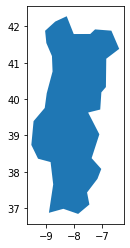

In [3]:
portugal.plot();

In [4]:
cutout = atlite.Cutout(
    path="port-era5-2019-05.nc",
    module="era5",
    bounds=portugal.iloc[0].geometry.bounds,
    time="2019-05",
)

cutout.prepare(["influx", "temperature"])

/home/fabian/vres/py/atlite/atlite/cutout.py:185: UserWarning: Arguments module, bounds, time are ignored, since cutout is already built.
  warn(


<Cutout "port-era5-2019-05">
 x = -9.50 ⟷ -6.50, dx = 0.25
 y = 37.00 ⟷ 42.25, dy = 0.25
 time = 2019-05-01 ⟷ 2019-05-31, dt = H
 module = era5
 prepared_features = ['influx', 'temperature']

## Calculate capacity factors for the three solar PV tracking options

- `tracking=None` for no tracking
- `tracking='horizontal'` for 1-axis horizontal tracking
- `tracking='tilted_horizontal'` for 1-axis horizontal tracking with tilted axis
- `tracking='vertical'` for 1-axis vertical tracking
- `tracking='dual'` for 2-axis tracking

### No tracking

In [5]:
cf_pv_0axis = cutout.pv(
    panel="CSi",
    orientation={"slope": 30.0, "azimuth": 180.0},
    shapes=cutout.grid,
    tracking=None,
    per_unit=True,
)

round(cf_pv_0axis.to_pandas().mean().mean(), 3)

0.233

### 1-axis horizontal tracking

In [6]:
cf_pv_1axis_h = cutout.pv(
    panel="CSi",
    orientation={"slope": 30.0, "azimuth": 180.0},
    shapes=cutout.grid,
    tracking="horizontal",
    per_unit=True,
)

round(cf_pv_1axis_h.to_pandas().mean().mean(), 3)

0.321

### 1-axis tilted-panel horizontal tracking

In [7]:
cf_pv_1axis_th = cutout.pv(
    panel="CSi",
    orientation={"slope": 30.0, "azimuth": 180.0},
    shapes=cutout.grid,
    tracking="tilted_horizontal",
    per_unit=True,
)

round(cf_pv_1axis_th.to_pandas().mean().mean(), 3)

0.322

### 1-axis vertical tracking

In [8]:
cf_pv_1axis_v = cutout.pv(
    panel="CSi",
    orientation={"slope": 30.0, "azimuth": 180.0},
    shapes=cutout.grid,
    tracking="vertical",
    per_unit=True,
)

round(cf_pv_1axis_v.to_pandas().mean().mean(), 3)

0.307

### 2-axis vertical tracking

In [9]:
cf_pv_2axis = cutout.pv(
    panel="CSi",
    orientation={"slope": 30.0, "azimuth": 180.0},
    shapes=cutout.grid,
    tracking="dual",
    per_unit=True,
)

round(cf_pv_2axis.to_pandas().mean().mean(), 3)

0.331

## Comparison of Time Series

In [10]:
cells = cutout.grid
point = cells[(cells["y"] == 42) & (cells["x"] == -9)].index
day = "2019-05-01"

In [11]:
data = [cf_pv_2axis, cf_pv_1axis_v, cf_pv_1axis_h, cf_pv_1axis_th, cf_pv_0axis]
labels = [
    "2-axis tracking",
    "1-axis vertical tracking",
    "1-axis horizontal tracking",
    "1-axis tilted horizontal tracking",
    "No tracking",
]

### Day Profile

Text(0.5, 1.0, 'PV Tracking: Portugal @(-9°, 40°), May 1, 2019')

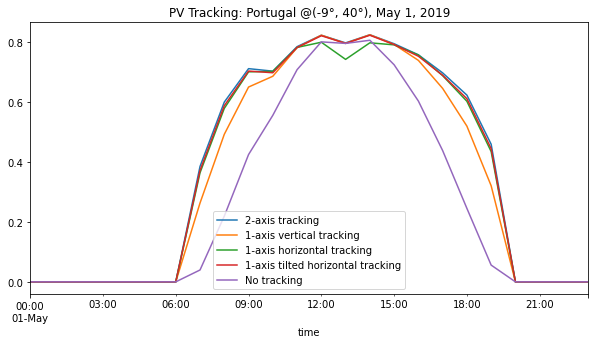

In [12]:
day_profiles = [ds.loc[day, point].squeeze() for ds in data]

df = pd.DataFrame({k: v.to_series() for k, v in zip(labels, day_profiles)})
df.plot(figsize=(10, 5))
plt.title("PV Tracking: Portugal @(-9°, 40°), May 1, 2019")

### Yearly Average

Text(0.5, 1.0, 'PV Tracking: Average Capacity Factor per Cell [%]')

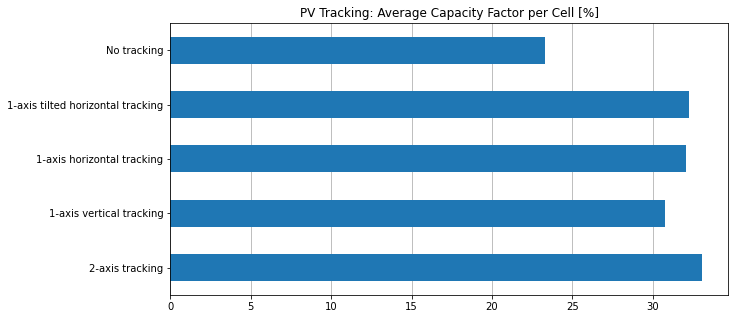

In [13]:
average = [ds.mean("dim_0").mean().item() for ds in data]
df = pd.Series({k: v for k, v in zip(labels, average)})
df.mul(100).plot.barh(figsize=(10, 5), zorder=2)
plt.grid(axis="x", zorder=1)
plt.title("PV Tracking: Average Capacity Factor per Cell [%]")